# **<center>Fish Classification with ANN</center>**
I built an Artificial Neural Network model for my entry-level project in the Global AI Hub Deep Learning Bootcamp. 

The goal was to create a model that can classify different fish species based on their images.

GitHub: [Fish-Classification-with-ANN](https://github.com/miraygurbuz/Fish-Classification-with-ANN)

You can find the dataset here: [A Large Scale Fish Dataset](https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset)

## **<center>Table of Contents</center>**
1. [Importing Libraries](#import)
2. [Data Preprocessing & Exploratory Data Analysis](#preprocessing)
3. [Model Training](#training)
4. [Model Evaluation](#evaluation)

<a id='import'></a>
## **<center>1. Importing Libraries</center>**

In [13]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

<a id='preprocessing'></a>
##  **<center> 2. Data Preprocessing & Exploratory Data Analysis </center>**

In [14]:
directory = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

### **Loading Image Data into a Dataframe**
This code goes through the directory to find all the .png files, skipping any directories named 'GT'. For each image, it stores its label and path in the lists.
These lists are organized into a dataframe with columns for 'path' and 'label'. 

In [15]:
label = []
path = []
for dir_name, _, filenames in os.walk(directory):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png': 
            if dir_name.split()[-1] != 'GT':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

### **Basic Info of the Data**

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [17]:
print(f"Number of elements in the data: {len(data)}")
num_classes = len(data['label'].unique())
print(f"Number of classes in the data: {num_classes}")

Number of elements in the data: 9000
Number of classes in the data: 9


### **Visualizing Class Frequencies**

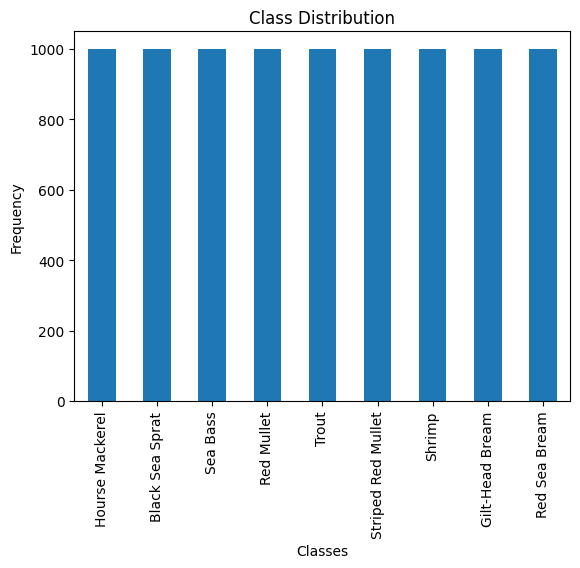

In [18]:
data['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

### **Visualizing Image Data**

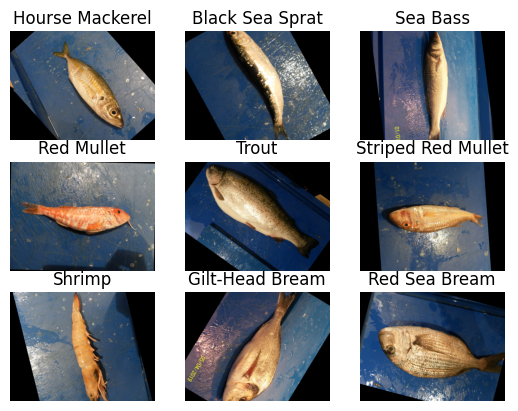

In [19]:
i = 0
unique_labels = data['label'].unique()
for unique_label in unique_labels:
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(data[data['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    i+=1

### **Train-Test Data Split**

In [20]:
#Preparing data
images = []
for img_path in data['path']:
    img = image.load_img(img_path, target_size=(112, 112))    
    images.append(np.array(img))

X = np.array(images)
y = data['label']
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

#Normalization
X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (5760, 112, 112, 3)
X_test shape: (1800, 112, 112, 3)
X_val shape: (1440, 112, 112, 3)


<a id='training'></a>
## **<center>3. Model Training</center>**
In this section, I created a function to build an Artificial Neural Network (ANN) model using Keras, which allows for hyperparameter optimization.

Hyperparameter optimization is something we do to make a model work better. Hyperparameters are settings that determine how the model behaves, like the number of neurons or how many layers it has.
* The function starts with an input layer that takes 112x112 RGB images and then flattens those images into a single line of numbers.
* After that I added dense layers with relu activation to help the model learn better.
* I included dropout layers to reduce overfitting.
* The final layer uses softmax activation which is great for multi-class classifications.
* The model is compiled with the Adam optimizer and categorical crossentropy loss to help it learn effectively.
To use this function, I created a parameter grid. This grid includes different values for the hyperparameters, which help improve the model. The options in this grid are the number of layers, the number of units in each layer, the dropout rate, and the strength of L2 regularization.

The code loops through all the combinations of these parameters, creates and trains a model for each one using the function. After training it checks the validation accuracy. If it's better than what we had before, it saves that model as the best one.

After finding the best combination, I commented out the loop and applied early stopping and learning rate reduction during model fitting to prevent overfitting and make the training smoother.

In [21]:
def create_model(num_layers, num_units, dropout_rate, l2_value):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(112, 112, 3)))
    model.add(layers.Flatten())
    
    for _ in range(num_layers):       
        model.add(layers.Dense(num_units, activation='relu',
                                kernel_regularizer=regularizers.l2(l2_value)))
        model.add(layers.Dropout(dropout_rate))
   
    model.add(layers.Dense(9, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

#Loop to find the best combination

'''param_grid = {
    'num_layers': [2, 3],
    'num_units': [128, 256, 512],
    'dropout_rate': [0.01, 0.1],
    'l2_value': [0.001, 0.0001]
}

grid = ParameterGrid(param_grid)

best_accuracy = 0
best_model = None

for params in grid:
    model = create_model(params['num_layers'], params['num_units'], params['dropout_rate'], params['l2_value'])
    history = model.fit(
        X_train, y_train, epochs=10, batch_size=128,
        validation_data=(X_val, y_val),
        verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
    
print(f"Best Validation Accuracy: {best_accuracy:.2f}")
best_model.summary()'''

lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=3,
                                 factor=0.2,
                                 min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,
                               restore_best_weights=True)

model = create_model(3, 256, 0.01, 0.001)
history = model.fit(
        X_train, y_train, epochs=100, batch_size=128,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[early_stopping, lr_reduction])
model.summary()

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.1742 - loss: 6.0407 - val_accuracy: 0.4382 - val_loss: 2.3818 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.4937 - loss: 2.1737 - val_accuracy: 0.6604 - val_loss: 1.6398 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.6608 - loss: 1.5868 - val_accuracy: 0.6785 - val_loss: 1.4678 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.7359 - loss: 1.3030 - val_accuracy: 0.7896 - val_loss: 1.1401 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7883 - loss: 1.0924 - val_accuracy: 0.8028 - val_loss: 1.0342 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.8394 - loss: 0.9442 - val_accuracy: 0.7785 - val_loss: 1.0840 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.8392 - loss:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 37632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,634,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,303,837 (111.79 MB)

 Trainable params: 9,767,945 (37.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,535,892 (74.52 MB)

<a id='evaluation'></a>
## **<center>4. Model Evaluation</center>**
In this section, the model's performance is evaluated.
* Training and validation loss & accuracy are visualized through plots, so we can see trends over the epochs.
* The confusion matrix helps us to understand how well the model performs for each class. It makes easier to see where the model gets things right or wrong.
* The classification report provides key performance metrics like precision, recall, and F1-score for each class.

### **Train/Validation Loss & Accuracy**

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9419 - loss: 0.4552
Test Loss: 0.4164891839027405, Test Accuracy: 0.9538888931274414


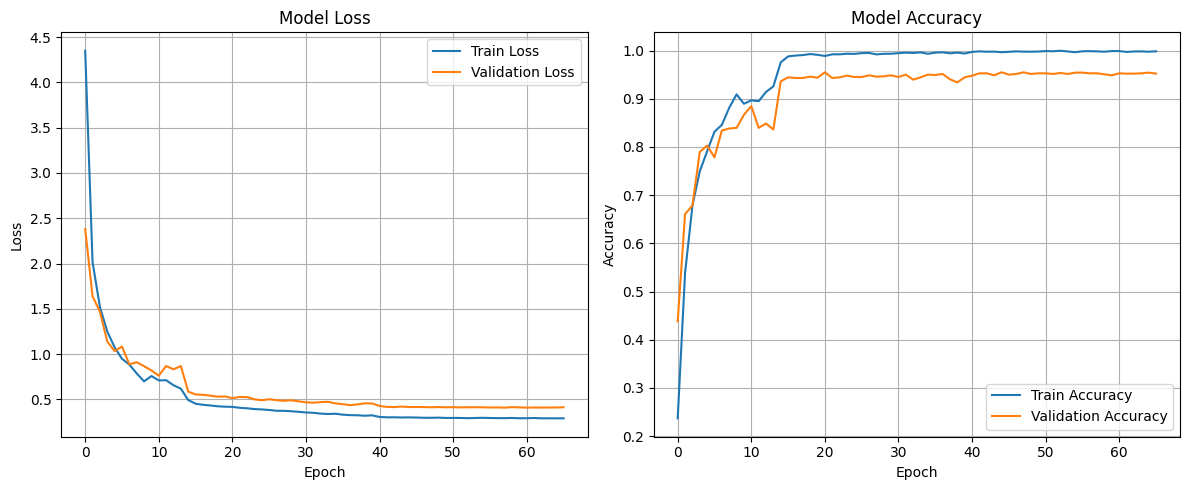

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### **Confusion Matrix and Classification Report**

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


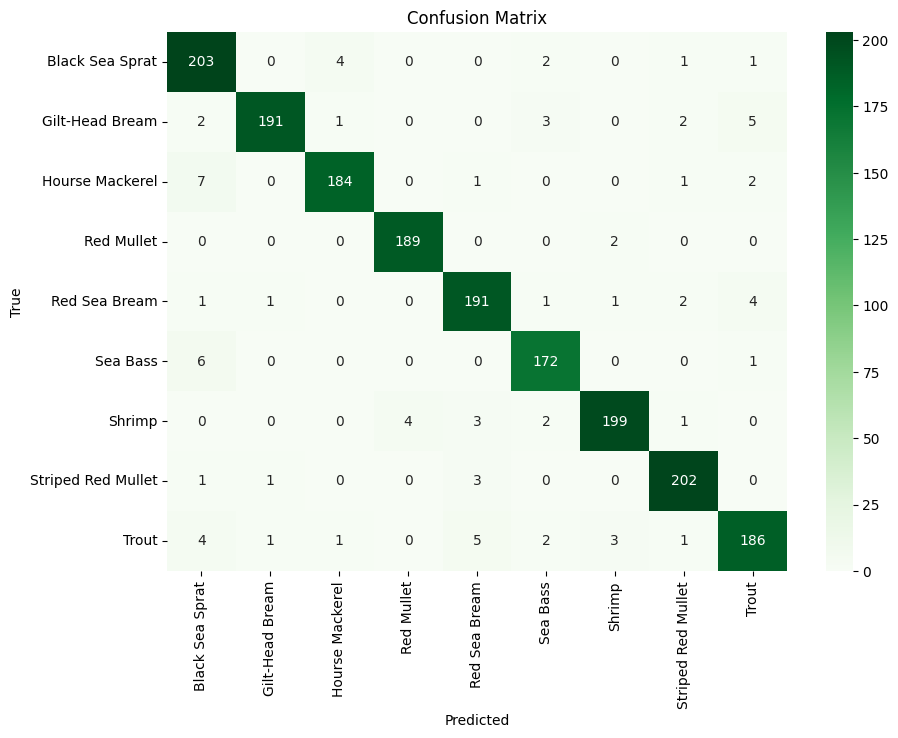

                    precision    recall  f1-score   support

   Black Sea Sprat       0.91      0.96      0.93       211
   Gilt-Head Bream       0.98      0.94      0.96       204
   Hourse Mackerel       0.97      0.94      0.96       195
        Red Mullet       0.98      0.99      0.98       191
     Red Sea Bream       0.94      0.95      0.95       201
          Sea Bass       0.95      0.96      0.95       179
            Shrimp       0.97      0.95      0.96       209
Striped Red Mullet       0.96      0.98      0.97       207
             Trout       0.93      0.92      0.93       203

          accuracy                           0.95      1800
         macro avg       0.95      0.95      0.95      1800
      weighted avg       0.95      0.95      0.95      1800



In [23]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = onehot_encoder.get_feature_names_out(['label'])
class_names = [name.split('_')[1] for name in class_names]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)